In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'/home/ubuntu/varios/skforecast'

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# set theme for matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregCustomDiff import ForecasterAutoregCustomDiff
from sklearn.linear_model import LinearRegression   
from sklearn.ensemble import RandomForestRegressor
from lineartree import LinearForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

Train dates : 1991-07-01 00:00:00 --- 2003-03-01 00:00:00  (n=141)
Test dates  : 2003-04-01 00:00:00 --- 2008-06-01 00:00:00  (n=63)


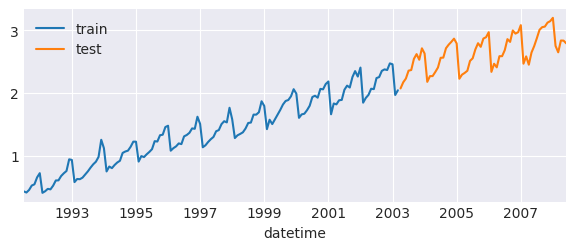

In [11]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o.csv'
)
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Add a smooth positive trend
# ==============================================================================
t = np.arange(len(data))
data = data + 0.01 * t

# Data partition train-test
# ==============================================================================
end_train = '2003-03-01 23:59:00'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend();

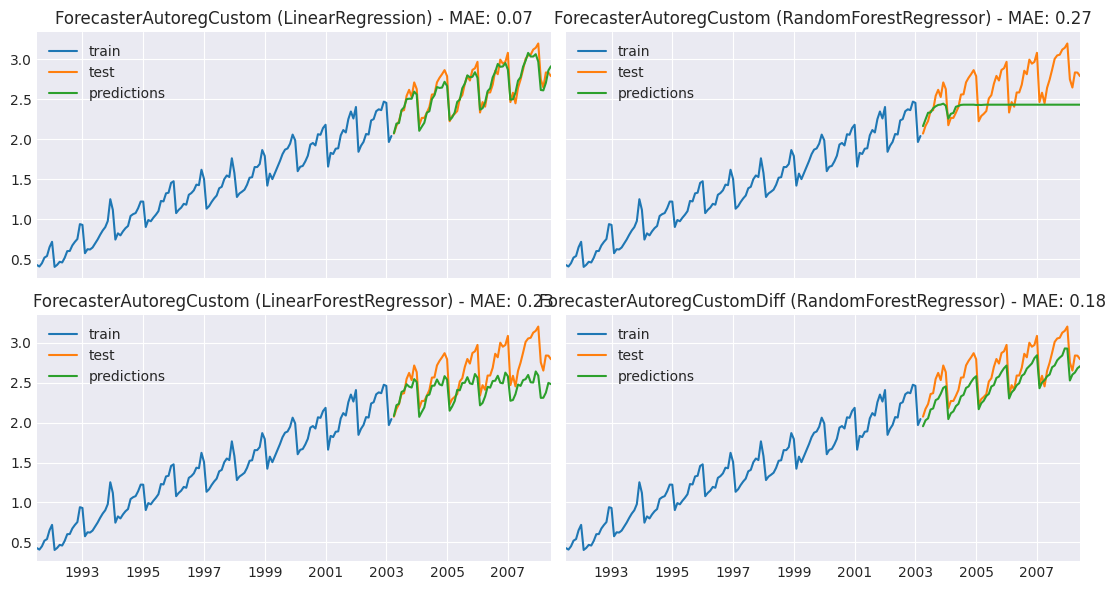

In [12]:
# Compare predictions of different models
# ==============================================================================

def create_predictors(y):
    """
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    """

    lags = y[-1:-16:-1]     # window_size = 10
    mean = np.mean(y[-21:]) # window_size = 20
    predictors = np.hstack([lags, mean])

    return predictors

regressors = [
    LinearRegression(),
    RandomForestRegressor(random_state=123),
    LinearForestRegressor(base_estimator=LinearRegression(), max_features='sqrt')
]

fig, ax = plt.subplots(2, 2, figsize=(11, 6), sharex=True, sharey=True)
ax = ax.ravel()

# ForecasterAutoreg Custom
for i, regressor in enumerate(regressors):
    forecaster = ForecasterAutoregCustom(
        regressor=regressor,
        fun_predictors=create_predictors,
        window_size=23
    )
    forecaster.fit(y=data.loc[:end_train])
    predictions = forecaster.predict(steps=len(data.loc[end_train:]))
    error = mean_absolute_error(data.loc[end_train:], predictions)
    data.loc[:end_train].plot(ax=ax[i], label='train')
    data.loc[end_train:].plot(ax=ax[i], label='test')
    predictions.plot(ax=ax[i], label='predictions')
    ax[i].set_title(
        f'ForecasterAutoregCustom ({forecaster.regressor.__class__.__name__}) - MAE: {error:.2f}',
        size=12
    )
    ax[i].set_xlabel('')
    ax[i].legend()

# ForecasterAutoregDiff with random forest
forecaster = ForecasterAutoregCustomDiff(
                 regressor       = RandomForestRegressor(random_state=123),
                 fun_predictors  = create_predictors,
                 window_size     = 30,
                 differentiation = 1
            )
forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
error = mean_absolute_error(data.loc[end_train:], predictions)
data.loc[:end_train].plot(ax=ax[3], label='train')
data.loc[end_train:].plot(ax=ax[3], label='test')
predictions.plot(ax=ax[3], label='predictions')
ax[3].set_title(
        f'ForecasterAutoregCustomDiff ({forecaster.regressor.__class__.__name__}) - MAE: {error:.2f}',
        size=12
    )
ax[3].set_xlabel('')
ax[3].legend()

fig.tight_layout()

In [13]:
forecaster = ForecasterAutoregCustomDiff(
                 regressor       = RandomForestRegressor(random_state=123),
                 fun_predictors  = create_predictors,
                 window_size     = 21,
                 differentiation = 1
            )

forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
predictions

2003-04-01    1.916970
2003-05-01    1.995600
2003-06-01    2.028075
2003-07-01    2.143270
2003-08-01    2.165854
                ...   
2008-02-01    2.477250
2008-03-01    2.561569
2008-04-01    2.562908
2008-05-01    2.646457
2008-06-01    2.671353
Freq: MS, Name: pred, Length: 63, dtype: float64

Train dates : 1949-01-01 00:00:00 --- 1955-01-01 00:00:00  (n=73)
Test dates  : 1955-01-01 00:00:00 --- 1960-12-01 00:00:00  (n=72)


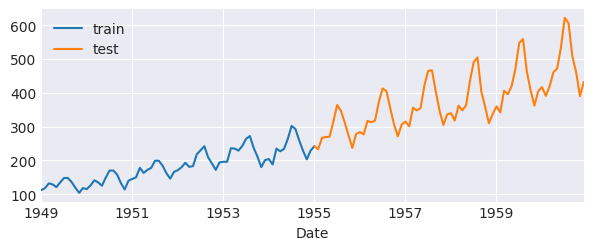

In [14]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/AirPassengers.csv'
)
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m')
data = data.set_index('Date')
data = data.asfreq('MS')
data = data['Passengers']
data = data.sort_index()


# # Data partition train-test
# # ==============================================================================
end_train = '1955-01-01'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend();

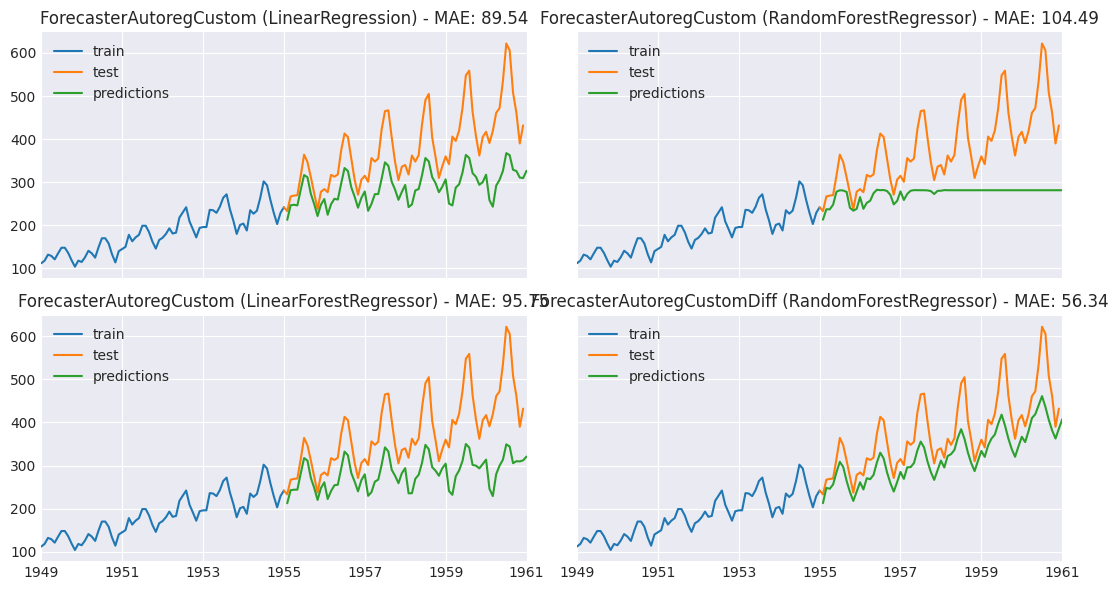

In [15]:
# Compare predictions of different models
# ==============================================================================

def create_predictors(y):
    """
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    """

    lags = y[-1:-16:-1]     # window_size = 10
    mean = np.mean(y[-21:]) # window_size = 20
    predictors = np.hstack([lags, mean])

    return predictors

regressors = [
    LinearRegression(),
    RandomForestRegressor(random_state=123),
    LinearForestRegressor(base_estimator=LinearRegression(), max_features='sqrt')
]

fig, ax = plt.subplots(2, 2, figsize=(11, 6), sharex=True, sharey=True)
ax = ax.ravel()

# ForecasterAutoreg Custom
for i, regressor in enumerate(regressors):
    forecaster = ForecasterAutoregCustom(
        regressor=regressor,
        fun_predictors=create_predictors,
        window_size=23
    )
    forecaster.fit(y=data.loc[:end_train])
    predictions = forecaster.predict(steps=len(data.loc[end_train:]))
    error = mean_absolute_error(data.loc[end_train:], predictions)
    data.loc[:end_train].plot(ax=ax[i], label='train')
    data.loc[end_train:].plot(ax=ax[i], label='test')
    predictions.plot(ax=ax[i], label='predictions')
    ax[i].set_title(
        f'ForecasterAutoregCustom ({forecaster.regressor.__class__.__name__}) - MAE: {error:.2f}',
        size=12
    )
    ax[i].set_xlabel('')
    ax[i].legend()

# ForecasterAutoregDiff with random forest
forecaster = ForecasterAutoregCustomDiff(
                 regressor       = RandomForestRegressor(random_state=123),
                 fun_predictors  = create_predictors,
                 window_size     = 30,
                 differentiation = 1
            )
forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
error = mean_absolute_error(data.loc[end_train:], predictions)
data.loc[:end_train].plot(ax=ax[3], label='train')
data.loc[end_train:].plot(ax=ax[3], label='test')
predictions.plot(ax=ax[3], label='predictions')
ax[3].set_title(
        f'ForecasterAutoregCustomDiff ({forecaster.regressor.__class__.__name__}) - MAE: {error:.2f}',
        size=12
    )
ax[3].set_xlabel('')
ax[3].legend()

fig.tight_layout()

/home/ubuntu/anaconda3/envs/skforecast_10_py11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Predictions sarimax


1955-02-01    226.620989
1955-03-01    258.327487
1955-04-01    262.469608
1955-05-01    268.924421
1955-06-01    298.486988
                 ...    
1960-09-01    451.777817
1960-10-01    436.189237
1960-11-01    427.408870
1960-12-01    437.445714
1961-01-01    448.158138
Freq: MS, Name: predicted_mean, Length: 72, dtype: float64

Predictions Forecaster


1955-02-01    179.291221
1955-03-01    214.212576
1955-04-01    210.461106
1955-05-01    219.801632
1955-06-01    252.690498
                 ...    
1960-09-01    371.068665
1960-10-01    350.405031
1960-11-01    322.045949
1960-12-01    343.558203
1961-01-01    340.278765
Freq: MS, Name: pred, Length: 72, dtype: float64

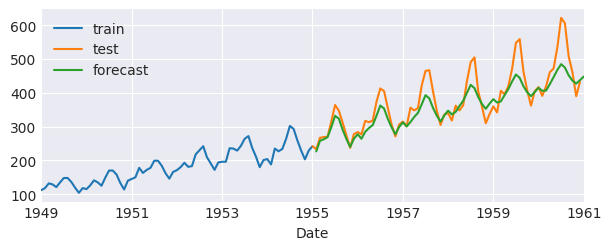

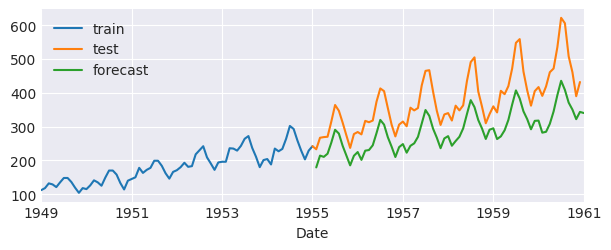

In [29]:
# Compare predictions with an arima (lags, 1, 0)
# ==============================================================================
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax = SARIMAX(data.loc[:end_train], order=(12, 2, 0))
res_sarimax = sarimax.fit(disp=False, maxiter=1000)
predictions = res_sarimax.get_forecast(len(data.loc[end_train:]))
print("Predictions sarimax")
display(predictions.predicted_mean)
fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions.predicted_mean.plot(ax=ax, label='forecast')
ax.legend();


def create_predictors(y):
    """
    Create first 12 lags of a time series.
    Calculate moving average with window 1.
    """

    lags = y[-1:-13:-1]   
    mean = np.mean(y[-2:]) 
    predictors = np.hstack([lags, mean])

    return predictors

forecaster = ForecasterAutoregCustomDiff(
                 regressor       = LinearRegression(),
                 window_size     = 13,
                 differentiation = 1,
                 fun_predictors  = create_predictors            )
            
forecaster.fit(y=data.loc[:end_train])
print("Predictions Forecaster")
predictions = forecaster.predict(len(data.loc[end_train:]))
display(predictions)
fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='forecast')
ax.legend();

In [18]:
# Bootstrapping predictions
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
            )
forecaster.fit(y=data.loc[:end_train])
boo_predictions = forecaster.predict_bootstrapping(
                        steps=len(data.loc[end_train:]),
                        n_boot=10
)
boo_predictions

,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9
1955-02-01,215.52,215.96,219.37,213.68,214.17,218.90,212.89,208.10,207.80,208.00
1955-03-01,240.30,231.22,247.84,231.12,231.12,239.22,241.95,230.58,233.49,241.95
1955-04-01,237.40,239.72,247.98,230.45,230.45,232.57,243.64,244.61,242.52,238.94
1955-05-01,250.51,250.17,241.72,242.26,248.10,252.96,239.34,251.61,253.90,243.54
1955-06-01,280.46,277.86,276.45,272.02,283.78,281.86,273.32,289.50,284.49,282.77
...,...,...,...,...,...,...,...,...,...,...
1960-09-01,272.49,279.49,283.10,277.94,276.97,283.98,282.71,277.78,283.14,278.10
1960-10-01,277.43,295.64,289.20,281.71,278.91,272.49,281.16,281.51,289.20,283.25
1960-11-01,284.79,284.47,282.71,277.31,284.36,285.93,292.72,278.75,281.21,285.19
1960-12-01,283.19,283.19,293.02,296.86,276.38,282.71,279.35,289.35,284.12,284.47


In [22]:
forecaster = ForecasterAutoregDiff(
                regressor=RandomForestRegressor(random_state=123),
                lags=12,
                differentiation=1
            )
forecaster.fit(y=data.loc[:end_train])
boo_predictions = forecaster.predict_bootstrapping(
                        steps=len(data.loc[end_train:]),
                        n_boot=10
)
boo_predictions

,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9
1955-02-01,183.80,186.38,180.74,184.33,180.74,186.97,184.33,182.45,184.19,185.36
1955-03-01,231.50,233.27,235.48,230.50,230.50,234.62,231.56,230.50,236.73,231.56
1955-04-01,198.78,193.95,192.85,199.87,198.86,195.67,196.42,202.28,202.91,205.64
1955-05-01,210.91,214.41,230.74,214.42,218.14,230.74,213.68,212.64,213.32,219.59
1955-06-01,224.76,216.94,224.11,217.16,217.84,219.97,220.28,224.66,227.12,218.93
...,...,...,...,...,...,...,...,...,...,...
1960-09-01,212.01,215.92,220.65,222.84,223.39,219.77,219.05,220.63,221.29,220.63
1960-10-01,216.29,226.40,223.41,219.62,224.49,212.01,227.18,220.15,223.41,219.54
1960-11-01,219.05,225.53,221.94,215.92,219.05,220.13,223.94,219.56,222.35,216.44
1960-12-01,220.77,220.77,223.94,229.57,217.77,221.94,218.22,234.54,219.25,225.53
